A motivating example: descriptive epidemiological meta-regression of Parkinson's Disease
========================================================================================

The goal of this document it give a concise demonstration of the 
strengths and limitations of DisMod-MR, the descriptive
epidemiological meta-regression tool developed for the Global Burden of Disease,
Injuries, and Risk Factors 2010 (GBD2010) Study.

A systematic review of PD was conducted as part of the GBD 2010
Study. The results of this
review---data on the prevalence, incidence, and standardized mortality ratio of
PD---needed to be combined to produce estimates of disease prevalence by
region, age, sex, and year.  These prevalence estimates were combined
with disability weights to measure years lived with disability (YLDs),
which were then combined with estimates of years of life lost (YLLs)
to produce estimates of the burden of PD quantified in disability-adjusted life-years (DALYs).

PD is a neurodegenerative disorder that includes symptoms of motor
dysfunction, such as tremors, rigidity, and akinesia, in the early
stages of the disease.  As the disease develops, most patients also
develop nonmotor symptoms, such as cognitive decline, dementia,
autonomic failure, and disordered sleep-wake regulation.  The standard
definition for PD diagnosis includes at least two of four cardinal
signs---resting tremor, bradykinesia, rigidity, and postural abnormalities.
There is no cure or treatments to slow the progression of the disease;
however, motor symptoms and disability may be improved with
symptomatic therapy.

This document works with simulated data, so that the dataset is fully distributable.  This data is included for understanding how to use DisMod-MR, and is not intended for the study of the descriptive epidemiology of PD.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, pymc as mc
import dismod_mr

ModuleNotFoundError: No module named 'numpy'


DisMod-MR uses the integrative systems modeling (ISM) approach to produce simultaneous
estimates of disease incidence, prevalence, remission, and mortality. The hallmark of
ISM is incorporating all available data.  In the case of Parkinson's Disease this
consists of population level measurements of incidence, prevalence, standardized mortality rate (SMR),
and cause-specific mortality rate (CSMR).

I will begin with a look at a subset of this data, however.  Only that from females in the Europe, Western GBD region.

In [ ]:
model = dismod_mr.data.load('pd_sim_data')
model.keep(areas=['all'], sexes=['female', 'total'])

kept 2218 rows of data


Of the 348 rows of data, here is how the values breakdown by data type:

In [ ]:
summary = model.input_data.groupby('data_type')['value'].describe()
np.round(summary,3).sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
data_type,,,,,,,,
m_all,924.0,0.071,0.131,0.000,0.002,0.008,0.063,0.553
csmr,819.0,0.000,0.000,0.000,0.000,0.000,0.000,0.001
p,404.0,0.005,0.007,0.000,0.000,0.002,0.006,0.052
i,61.0,0.001,0.001,0.000,0.000,0.000,0.001,0.008
smr,10.0,4.384,7.442,1.115,1.369,1.997,2.822,25.430


More than half of the available data for this region is prevalence data.  I'll take a closer look
at that now.

In [ ]:
model.get_data('smr').value.mean()

4.384238512314999

In [ ]:
groups = model.get_data('p').groupby('area')
print(np.round_(groups['value'].describe(),3).sort_values('50%', ascending=False))

                count   mean    std    min    25%    50%    75%    max
area                                                                  
CUB               1.0  0.013    NaN  0.013  0.013  0.013  0.013  0.013
URY               2.0  0.011  0.006  0.007  0.009  0.011  0.014  0.016
SGP               4.0  0.011  0.012  0.000  0.004  0.009  0.017  0.028
oceania           1.0  0.008    NaN  0.008  0.008  0.008  0.008  0.008
TUN               1.0  0.007    NaN  0.007  0.007  0.007  0.007  0.007
NGA               2.0  0.007  0.006  0.003  0.005  0.007  0.009  0.011
AUT               1.0  0.006    NaN  0.006  0.006  0.006  0.006  0.006
europe_western   13.0  0.007  0.006  0.000  0.001  0.006  0.013  0.017
NZL               5.0  0.004  0.003  0.001  0.002  0.006  0.006  0.006
ESP              43.0  0.006  0.007  0.000  0.001  0.006  0.009  0.037
FRA              19.0  0.007  0.008  0.000  0.001  0.005  0.010  0.027
FIN               1.0  0.004    NaN  0.004  0.004  0.004  0.004  0.004
NLD   

In the original dataset, there was a wide range in median values, which reflects a combination of country-to-country variation and compositional bias.  Simulating data has reduced this substantially, but there is still six-fold variation between ESP and GBR.

In [7]:
countries = ['ESP', 'GBR']
c = {}
for i, c_i in enumerate(countries):
    c[i] = groups.get_group(c_i)

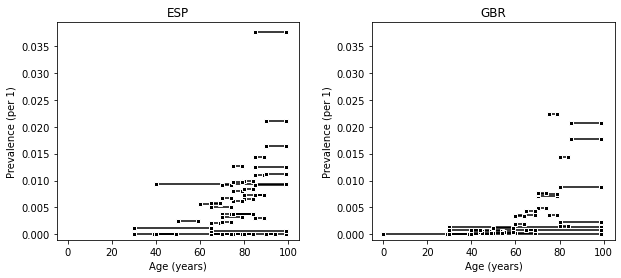

In [ ]:
ax = None
plt.figure(figsize=(10,4))
for i, c_i in enumerate(countries):
    ax = plt.subplot(1,2,1+i, sharey=ax, sharex=ax)
    dismod_mr.plot.data_bars(c[i])
    plt.xlabel('Age (years)')
    plt.ylabel('Prevalence (per 1)')
    plt.title(c_i)
plt.axis(ymin=-.001, xmin=-5, xmax=105)
plt.subplots_adjust(wspace=.3)

A model for age-specific parameters when measurements have heterogeneous age groups
-----------------------------------------------------------------------------------

DisMod-MR has four features that make it particularly suited for estimating age-specific prevalence of PD from this data:

* Piecewise linear spline model for change in prevalence as a function of age
* Age-standardizing model of age-group heterogeneity represents the heterogeneous age groups collected in systematic review
* Country-level random effects for true variation in prevalence between countries
* Negative binomial model of data, which provides data-driven estimation of non-sampling error in measurements
  and elegantly handles measurements of 0

I will now fit the prevalence data with DisMod-MR's age-standardizing negative binomial random effect spline model and
compare the estimates to the observed data.  Then I will use the results of the fit model to explore the four features listed above.

In [9]:
# remove fixed effects for this example, I will return to them below
model.input_data = model.input_data.filter(regex='(?!x_)')

In [ ]:

model.vars += dismod_mr.model.asr(model, 'p')

# model.describe('p')

# %time dismod_mr.fit.asr(model, 'p',verbose=True)


data================


/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


AttributeError: 'Deterministic' object has no attribute 'trace'

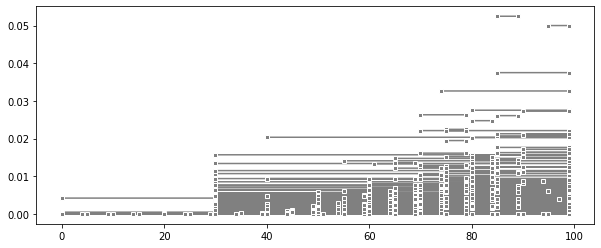

In [ ]:
# plot age-specific prevalence estimates over data bars
plt.figure(figsize=(10,4))

dismod_mr.plot.data_bars(model.get_data('p'), color='grey', label='Simulated PD Data')

pred = dismod_mr.model.predict_for(model=model, 
                                   parameters=model.parameters['p'], 
                                   root_area='all', root_sex='female', root_year= 2009,
                                   area     ='GBR', sex=     'female', year=      2005,
                                   population_weighted=1.,
                                   vars=model.vars['p'], 
                                   lower=0., upper=1.)    # TODO: simplify this method!

hpd = mc.utils.hpd(pred, .05)
# Highest Posterior Density

plt.plot(np.arange(101), pred.mean(axis=0), 'k-', linewidth=2, label='Posterior Mean')
plt.plot(np.arange(101), hpd[0,:], 'k--', linewidth=1, label='95% HPD interval')
plt.plot(np.arange(101), hpd[1,:], 'k--', linewidth=1)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')

plt.axis(ymin=-.001, xmin=-5, xmax=105);

print(pred[500,-5:])

In [13]:
p_only = model  # store results for future comparison

This estimate shows the nonlinear increase in prevalence as a function of age, where the slope of the
curve increases at age 60.  A nonlinear estimate like this is possible thanks to DisMod-MR's piecewise linear
spline model.

The age-standardizing model for heterogeneous age groups is also important for
such settings; a naive approach, such as using the age interval midpoint, would result in under-estimating
the prevalence for age groups that include both individuals older and younger than 60.


The exact age where the slope of the curve changes is _not_ entirely data driven in this example.  The knots
in the piecewise linear spline model were chosen a priori, on the following grid:

In [ ]:
model.parameters['p']['parameter_age_mesh']

[0, 30, 45, 60, 80, 100]

A sparse grid allows faster computation, but a dense grid allows more expressive age pattens.  Choosing
the proper balance is one challenge of a DisMod-MR analysis.  This is especially true for sparse,
noisy data, where too many knots allow the model to follow noisy idiosyncrasies of the data.  DisMod-MR
allows for penalized spline regression to help with this choice.

The country-level random effects in this model capture country-to-country variation in PD prevalence.
This variation is not visible in the graphic above, which shows the regional aggregation of country-level
estimates (using a population weighted average that takes uncertainty into account).

The country-level random effects take the form of intercept shifts in log-prevalence space, with values
showing in the following:

In [15]:
df = pd.DataFrame(index=[alpha_i.__name__ for alpha_i in model.vars['p']['alpha']],
                      columns=['mean', 'lb', 'ub'])
for alpha_i in model.vars['p']['alpha']:
    trace = alpha_i.trace()
    hpd = mc.utils.hpd(trace, .05)
    df.loc[alpha_i.__name__] = (np.mean(trace), hpd[0], hpd[1])

In [ ]:
print(np.round(df.astype(float),3).sort_values('mean', ascending=False))

                                    mean     lb     ub
alpha_p_latin_america_southern     0.064 -0.082  0.214
alpha_p_ARG                        0.046 -0.126  0.169
alpha_p_north_africa_middle_east   0.031 -0.136  0.162
alpha_p_AUT                        0.026 -0.118  0.171
alpha_p_COL                        0.024 -0.086  0.143
alpha_p_CUB                        0.022 -0.098  0.146
alpha_p_NOR                        0.021 -0.103  0.193
alpha_p_australasia                0.018 -0.131  0.154
alpha_p_asia_south                 0.018 -0.129  0.153
alpha_p_NZL                        0.018 -0.154  0.135
alpha_p_ETH                        0.018 -0.098  0.149
alpha_p_TUN                        0.017 -0.133  0.156
alpha_p_SGP                        0.017 -0.088  0.163
alpha_p_latin_america_central      0.015 -0.133  0.174
alpha_p_super-region_2             0.014 -0.129  0.143
alpha_p_super-region_6             0.012 -0.130  0.148
alpha_p_USA                        0.011 -0.126  0.109
alpha_p_IN

The fourth feature of the model which I want to draw attention to here is the negative binomial model of data,
which deals with measurements of zero prevalence in a principled way.  Prevalence studies are reporting transformations
of count data, and count data can be zero.  In the case of prevalence of PD in 30- to 40-year-olds, it often _will_ be zero.

In [ ]:
model.get_data('p').sort_values('age_start').filter(['age_start', 'age_end', 'area', 'value']).head(15)

,age_start,age_end,area,value
641,0,99,CHN,0.004200
571,0,49,BGR,0.000049
572,0,49,BGR,0.000158
394,0,54,ITA,0.000467
559,0,4,PRT,0.000000
187,0,29,GBR,0.000000
1416,0,44,USA,0.000052
560,0,39,EST,0.000000
444,0,34,ITA,0.000003
371,0,49,ITA,0.000000


The negative binomial model has an appropriately skewed distribution, where prevalence measurements 
of zero are possible, but measurements of less than zero are not possible.  To demonstrate how this
functions, the next figure shows the "posterior predictive distribution" for the measurements above,
i.e. sample values that the model predicts would be found of the studies were conducted again under
the same conditions.

In [18]:
pred = model.vars['p']['p_pred'].trace()
obs = np.array(model.vars['p']['p_obs'].value)
ess = np.array(model.vars['p']['p_obs'].parents['n'])

Text(0.5, 1.0, 'Posterior Predictive distribution')

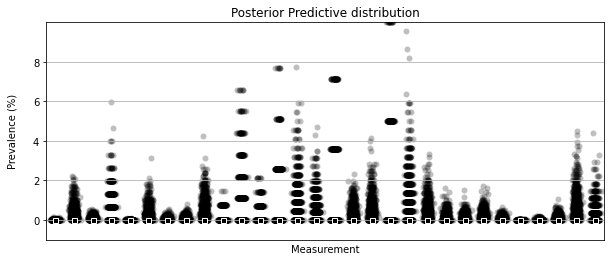

In [ ]:
plt.figure(figsize=(10,4))

sorted_indices = obs.argsort().argsort()
jitter = mc.rnormal(0, .1**-2, len(pred))

for i,s_i in enumerate(sorted_indices):
    plt.plot(s_i+jitter, pred[:, i], 'ko', mew=0, alpha=.25, zorder=-99)

plt.errorbar(sorted_indices, obs, yerr=1.96*np.sqrt(obs*(1-obs)/ess), fmt='ks', mew=1, mec='white', ms=5)

plt.xticks([])
plt.xlabel('Measurement')
plt.ylabel('Prevalence (%)\n', ha='center')
plt.yticks([0, .02, .04, .06, .08], [0, 2, 4, 6, 8])
plt.axis([25.5,55.5,-.01,.1])
plt.grid()
plt.title('Posterior Predictive distribution')

Additional features of DisMod-MR
--------------------------------

Four additional features of DisMod-MR that are important for many settings are:

* informative priors
* fixed effects to cross-walk between different studies
* fixed effects to predict out of sample
* fixed effects to explain the level of variation

Informative priors are useful for modeling disease with less data available than PD, for example to include
information that prevalence is zero for youngest ages, or than prevalence must be increasing as a function of
age between certain ages.

The informative priors are also key to the "empirical Bayes" approach to modeling age-specific differences between
difference GBD regions.  In this setting, a model using all the world's data is used to produce estimates for each region,
and these estimates are used as priors in region-specific models together with the data relevant to that region only.

"Cross-walk" fixed effects can correct for biases introduced by multiple outcome measures.  For example, in the PD dataset,

In [20]:
model = dismod_mr.data.load('pd_sim_data')

In [21]:
crosswalks = list(model.input_data.filter(like='x_cv').columns)
groups = model.get_data('p').groupby(crosswalks)

In [ ]:
crosswalks

['x_cv_ascertainment', 'x_cv_diagnostic_criteria', 'x_cv_representative']

In [ ]:
np.round(groups['value'].describe(),3).unstack()['mean'].fillna('-')

x_cv_representative                              0      1
x_cv_ascertainment x_cv_diagnostic_criteria              
0                  0                         0.006      -
                   1                         0.009      -
1                  0                         0.004      -
                   1                         0.004  0.009

Incorporating data on parameters other than prevalence
------------------------------------------------------

So far this example has focused on modeling the prevalence of PD from the
prevalence data alone.  However, this represents about half of the available
data.  There is also information on incidence, SMR, and CSMR, which has not
yet been incorporated.

DisMod-MR is capable of including all of the available data, using a compartmental
model of disease moving through a population.  This model formalizes the observation
that prevalent cases must once have been incident cases, and continue to be prevalent
cases until remission or death.

In this model, incidence, remission, and excess-mortality are age-standardizing negative binomial random effect spline models,
while prevalence, SMR, CSMR, and other parameters come from the solution to a system of ordinary differential equations.

The results of this model are smoother prevalence curves that take longer to calculate.

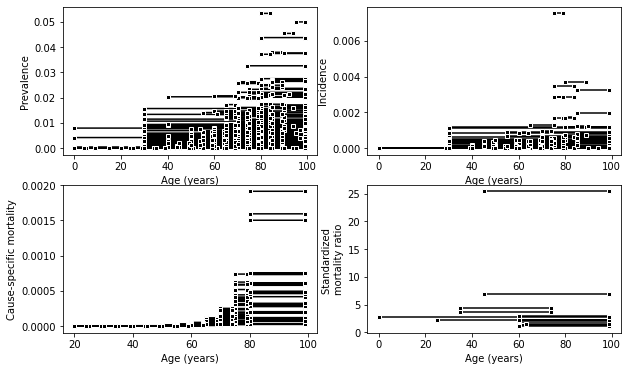

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1); dismod_mr.plot.data_bars(model.get_data('p')); plt.xlabel('Age (years)'); plt.ylabel('Prevalence')
plt.subplot(2,2,2); dismod_mr.plot.data_bars(model.get_data('i')); plt.xlabel('Age (years)'); plt.ylabel('Incidence')
plt.subplot(2,2,3); dismod_mr.plot.data_bars(model.get_data('csmr')); plt.xlabel('Age (years)'); plt.ylabel('Cause-specific mortality')
plt.subplot(2,2,4); dismod_mr.plot.data_bars(model.get_data('smr')); plt.xlabel('Age (years)'); plt.ylabel('Standardized \nmortality ratio');

In [ ]:
model.input_data.columns

Index(['index', 'age_end', 'age_start', 'age_weights', 'area', 'data_type',
       'effective_sample_size', 'lower_ci', 'sex', 'standard_error',
       'upper_ci', 'value', 'x_cv_ascertainment', 'x_cv_diagnostic_criteria',
       'x_cv_representative', 'year_end', 'year_start'],
      dtype='object')

In [ ]:
# model.vars += dismod_mr.model.consistent(model)
# %time dismod_mr.fit.consistent(model)

all
      CHN  ESP  EST  FIN  GBR  ITA  JPN  LBY  NLD  POL  ...  \
23    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
25    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
26    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
27    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
28    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1411  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1412  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1413  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      asia_pacific_high_income  europe_central  europe_eastern  \
23                         0.0             0.0             0.0   
25                         0.0             0.0             0.0   
26                         0.0           

/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


all
      ARG  AUS  AUT  BGR  BOL  CAN  CHL  CHN  COL  CUB  ...  oceania  \
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
8     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...   
2405  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
2406  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
2407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
2408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
2409  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   

      sub-saharan_africa_east  sub-saharan_africa_west  super-region_0  \
4                         0.0                      0.0   

/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Empty DataFrame
Columns: [all, AFG, AGO, ALB, AND, ARE, ARG, ARM, ATG, AUS, AUT, AZE, BDI, BEL, BEN, BFA, BGD, BGR, BHR, BHS, BIH, BLR, BLZ, BOL, BRA, BRB, BRN, BTN, BWA, CAF, CAN, CHE, CHL, CHN, CIV, CMR, COD, COG, COL, COM, CPV, CRI, CUB, CYP, CZE, DEU, DJI, DMA, DNK, DOM, DZA, ECU, EGY, ERI, ESP, EST, ETH, FIN, FJI, FRA, FSM, GAB, GBR, GEO, GHA, GIN, GMB, GNB, GNQ, GRC, GRD, GTM, GUY, HND, HRV, HTI, HUN, IDN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM, JOR, JPN, KAZ, KEN, KGZ, KHM, KIR, KOR, KWT, LAO, LBN, LBR, LBY, LCA, ...]
Index: []

[0 rows x 216 columns]
using stored FE for beta_X_x_cv_ascertainment x_cv_ascertainment {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_cv_diagnostic_criteria x_cv_diagnostic_criteria {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_cv_representative x_cv_representative {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_sex x_sex {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
fitting

/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


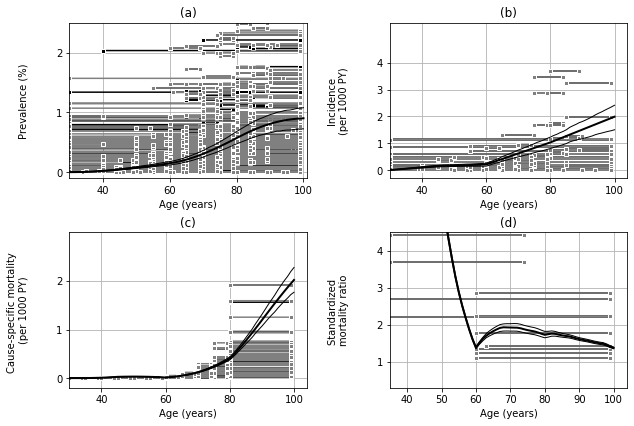

In [25]:
# plt.figure(figsize=(10,6))

# plt.subplot(2,2,1); dismod_mr.plot.data_bars(model.get_data('p')); plt.xlabel('Age (years)'); plt.ylabel('Prevalence')
# plt.subplot(2,2,2); dismod_mr.plot.data_bars(model.get_data('i')); plt.xlabel('Age (years)'); plt.ylabel('Incidence')
# plt.subplot(2,2,3); dismod_mr.plot.data_bars(model.get_data('csmr')); plt.xlabel('Age (years)'); plt.ylabel('Cause-specific mortality')
# plt.subplot(2,2,4); dismod_mr.plot.data_bars(model.get_data('smr')); plt.xlabel('Age (years)'); plt.ylabel('Standardized \nmortality ratio')
# param_list = [dict(type='p', title='(a)', ylabel='Prevalence (%)', yticks=([0, .01, .02], [0, 1, 2]), axis=[30,101,-0.001,.025]),
#           dict(type='i', title='(b)', ylabel='Incidence \n(per 1000 PY)', yticks=([0, .001,.002, .003, .004], [0, 1, 2, 3, 4]), axis=[30,104,-.0003,.0055]),
#           dict(type='pf', title='(c)', ylabel='Cause-specific mortality \n(per 1000 PY)', yticks=([0, .001,.002], [0, 1, 2]), axis=[30,104,-.0002,.003]),
#           dict(type='smr', title='(d)', ylabel='Standardized \nmortality ratio', yticks=([1, 2, 3,4, ], [1, 2,3, 4]), axis=[35,104,.3,4.5]),
#           ]

# for i, params in enumerate(param_list):
#     ax = plt.subplot(2,2,i+1)
#     if params['type'] == 'pf': dismod_mr.plot.data_bars(model.get_data('csmr'), color='grey')
#     else: dismod_mr.plot.data_bars(model.get_data(params['type']), color='grey')
    
#     if params['type'] == 'smr': model.pred = dismod_mr.model.predict_for(model, model.parameters.get('smr', {}), 'all', 'female', 2005, 
#                                                                'GBR', 'female', 2005, 1., model.vars['smr'], 0., 100.).T
#     else : model.pred = dismod_mr.model.predict_for(model, model.parameters[params['type']],
#                                                        'all', 'female', 2005, 
#                                                        'GBR', 'female', 2005, 1., model.vars[params['type']], 0., 1.).T
    
#     plt.plot(np.arange(101), model.pred.mean(axis=1), 'k-', linewidth=2, label='Posterior Mean')
#     hpd = mc.utils.hpd(model.pred.T, .05)
#     plt.plot(np.arange(101), hpd[0], 'k-', linewidth=1, label='95% HPD interval')
#     plt.plot(np.arange(101), hpd[1], 'k-', linewidth=1)

#     plt.xlabel('Age (years)')
#     plt.ylabel(params['ylabel']+'\n\n', ha='center')
#     plt.axis(params.get('axis', [-5,105,-.005,.06]))
#     plt.yticks(*params.get('yticks', ([0, .025, .05], [0, 2.5, 5])))
#     plt.title(params['title'])
#     plt.grid()
    
# plt.subplots_adjust(hspace=.35, wspace=.35, top=.97)

In [26]:
p_with = model

The most notable difference between the estimates from this model and from the model
that used prevalence data only is that this model produces estimates of incidence and
mortality in addition to prevalence.  In many cases, the model also produces estimates
of the remission rate as well, but there is no remission of PD, so the estimates of zero
are not very interesting in this example.  It is another place that informative priors are useful,
however.

There are also differences between the means and uncertainty intervals estimated by these methods,
which show that the additional data is important.  Although the prevalence data alone predicts 
age-specific prevalence that peaks at 2%, when the incidence and mortality data is also included, the
maximum prevalence is a bit lower, closer to 1.5%.

In [27]:
# p1 = dismod_mr.model.predict_for(p_only, model.parameters['p'],
#                                     'all', 'total', 'all', 
#                                     'GBR', 'female', 2005, 1.,
#                                     p_only.vars['p'], 0., 1.)

# p2 = dismod_mr.model.predict_for(p_with, model.parameters['p'],
#                                     'all', 'total', 'all', 
#                                     'GBR', 'female', 2005, 1.,
#                                     p_with.vars['p'], 0., 1.)

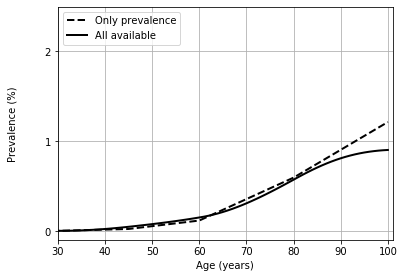

In [28]:
# plt.plot(p1.mean(axis=0), 'k--', linewidth=2, label='Only prevalence')
# plt.plot(p2.mean(axis=0), 'k-', linewidth=2, label='All available')

# plt.xlabel('Age (years)')
# plt.ylabel('Prevalence (%)\n\n', ha='center')
# plt.yticks([0, .01, .02], [0, 1, 2])
# plt.axis([30,101,-0.001,.025])
# plt.legend(loc='upper left')
# plt.grid()

# plt.subplots_adjust(top=.97, bottom=.16)

Because the data is so noisy, the differences between the mean estimates of these different models are not significant; the posterior distributions
have considerable overlap.  At age 80, for example, the posterior distributions for age-80 prevalence are estimated as the following:

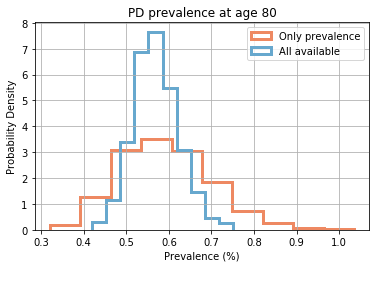

In [29]:
plt.hist(100*p1[:,80], density=True, histtype='step', label='Only prevalence', linewidth=3, color=np.array([239., 138., 98., 256.])/256)
plt.hist(100*p2[:,80], density=True, histtype='step', label='All available', linewidth=3, color=np.array([103, 169, 207, 256.])/256)
plt.title('PD prevalence at age 80')
plt.xlabel('Prevalence (%)\n\n', ha='center')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.grid()

plt.subplots_adjust(bottom=.16)

Conclusion
==========

I hope that this example is a quick way to see the strengths and weaknesses of DisMod-MR.
This model is particularly suited for estimating descriptive epidemiology of diseases
with sparse, noisy data from multiple, incompatible sources.

I am currently working to make it faster, as well as to improve the capabilities for modeling
changes between regions over time.

In [19]:
!date

Tue Apr 29 15:47:18 EDT 2025
